In [1]:
import numpy as np
from scipy import signal


In [2]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import imageio

In [3]:
def getSIFTkeypoints(img, jmp = 1):
    """
        Return SIFT keypoints
        :param img: input image
        :param jmp: points t skip
    """
    
    sift = cv2.SIFT_create()
    kp = sift.detect(img,None)
    kp = kp[::jmp]
    kpts = [x.pt for x in kp]
    kpts = [(round(x),round(y)) for x,y in kpts]
    
    return kpts

In [4]:
def getMyFeatures(image):
    feature_params = dict( maxCorners = 100,qualityLevel = 0.1,minDistance = 7, blockSize = 7 )
    kpts = cv2.goodFeaturesToTrack(image, mask = None, **feature_params)
    kpts = [i.ravel() for i in kpts]
    kpts = [(round(x),round(y)) for x,y in kpts]
    return kpts

In [5]:
def clipToImg(u,v,image):
    u = np.clip(u,0,image.shape[0]-1)
    v = np.clip(v,0,image.shape[1]-1)
    return u,v

In [6]:
from random import randint
def visualize_keypoints(keypoints, img):
    """
    Visualize the keypoints on the image
    :param keypoints: keypoints of the image
    :param img: input image
    """
    plt.figure()
    newImg = img.copy()
    for i,j in keypoints:
        borderColor = (57, 255, 20)
        randomColor = (randint(0,255), randint(0,255), randint(0,255))
        newImg = cv2.circle(newImg, (i, j), 4, randomColor, -1, cv2.LINE_AA)
        newImg = cv2.circle(newImg, (i, j), 4, borderColor, 1, cv2.LINE_AA)
    
    plt.imshow(newImg)

In [7]:
def colorCode(u,v):
    """
    Return the appropriate colorCode
    :param u: x-velocity
    :param v: y-velocity
    """

    if(u>=0):
        if(v>=0):
            # first quadrant
            return (199,21,133)
        else:
            # second quadrant
            return (0,0,255)
    else:
        if(v>=0):
            # fourth quadrant
            return (0, 255, 0)
        else:
            # third quadrant
            return (255,69,0)
    

In [8]:
def getSmoothImages(img1, img2, filterSize=3):
    """Return the smoothed images"""
    img1 = cv2.GaussianBlur(img1,(filterSize,filterSize),0)
    img2 = cv2.GaussianBlur(img2,(filterSize,filterSize),0)
    return img1, img2


In [9]:
def getLKFlow(Ix, Iy, It,features,imgShape):
    """
        Get the LK flow  (Av = b)
        :param Ix: x-derivative of the image
        :param Iy: y-derivative of the image
        :param It: time derivative of the image

        :param features: keypoints
        :param imgShape: shape of the image

        :return: flow
    """
    u = v = np.nan*np.ones(imgShape)
	
	# Calculating the u and v arrays
    for l in features:
        j,i = l.ravel()
        IX = ([Ix[i-1,j-1],Ix[i,j-1],Ix[i-1,j-1],Ix[i-1,j],Ix[i,j],Ix[i+1,j],Ix[i-1,j+1],Ix[i,j+1],Ix[i+1,j-1]]) #The x-component of the gradient vector
        IY = ([Iy[i-1,j-1],Iy[i,j-1],Iy[i-1,j-1],Iy[i-1,j],Iy[i,j],Iy[i+1,j],Iy[i-1,j+1],Iy[i,j+1],Iy[i+1,j-1]]) #The Y-component of the gradient vector
        IT = ([It[i-1,j-1],It[i,j-1],It[i-1,j-1],It[i-1,j],It[i,j],It[i+1,j],It[i-1,j+1],It[i,j+1],It[i+1,j-1]]) #The XY-component of the gradient vector
		
		# Using the minimum least squares solution approach
        A = (IX, IY)
        A = np.matrix(A)
        A_T = np.array(np.matrix(A)) # transpose of A
        A = np.array(np.matrix.transpose(A)) 
        
        A1 = np.dot(A_T,A) #Psedudo Inverse
        A2 = np.linalg.pinv(A1)
        A3 = np.dot(A2,A_T)
        
        (u[i,j],v[i,j]) = np.dot(A3,IT)
    
    return u,v

In [10]:
def LK_OpticalFlow(Image1,Image2):
    '''
        Implements the LK optical flow estimation algorithm with two frame data.
    '''
    I1 = cv2.cvtColor(Image1, cv2.COLOR_BGR2GRAY)
    I2 = cv2.cvtColor(Image2, cv2.COLOR_BGR2GRAY)

    I1 = np.array(I1)
    I2 = np.array(I2)
    S = np.shape(I1)

	#applying Gaussian filter of size 3x3 to eliminate any noise
    I1_smooth, I2_smooth = getSmoothImages(I1, I2, 3)
    
	# First Derivative in X direction
    Ix = signal.convolve2d(I1_smooth,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,0.25],[-0.25,0.25]],'same')
	# First Derivative in Y direction
    Iy = signal.convolve2d(I1_smooth,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,-0.25],[0.25,0.25]],'same')
    # First Derivative in T direction
    It = signal.convolve2d(I1_smooth,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2_smooth,[[-0.25,-0.25],[-0.25,-0.25]],'same')
	
	# finding the good features
    features = getSIFTkeypoints(I1,1)
    feature = np.int0(features)
    
	#Initializing the u and v vector
     
    u,v = getLKFlow(Ix,Iy,It,feature, S)
    # plt.figure()
    t = 0.3
    masked_scale = 0.2
    mask = np.zeros_like(Image1)
    for i in range(S[0]):
        for j in range(S[1]):
            if abs(u[i,j])>t or abs(v[i,j])>t: # setting the threshold to plot the vectors
                pt1 = j,i
                pt2 = round(j+v[i,j]), round(i+u[i,j])
                pt3 = round(j+masked_scale*v[i,j]), round(i+masked_scale*u[i,j])
                # print(pt1, pt2)
                mask = cv2.circle(mask, pt1, 2, colorCode(u[i,j], v[i,j]), -1)
                mask = cv2.arrowedLine(mask,pt1,pt3,colorCode(u[i,j], v[i,j]),2)
                Image1 = cv2.arrowedLine(Image1,pt1,pt2,colorCode(u[i,j], v[i,j]),2)
    return Image1, mask

In [11]:
image_name = 'walking.gif'
file_name = image_name.split('.')[0]
cap = cv2.VideoCapture(image_name)
ret, old_frame = cap.read()
allImages = []
maskedImgs = []
while True:
    ret, new_frame = cap.read()
    if ret:
        flowImg, maskImg = LK_OpticalFlow(old_frame,new_frame)
        allImages.append(flowImg)
        maskedImgs.append(maskImg)
        old_frame = new_frame
    else:
        break
cap.read()
imageio.mimsave('LK_OpticalFlow_'+file_name+".gif", allImages, fps = 4)


In [12]:
imageio.mimsave(file_name+'_masked.gif', maskedImgs, fps = 7)

## Stereo

In [1]:
import cv2
import os
import numpy as np 



# di = os.listdir("input")
# image1 = os.path.join("input",di[0])
# image2 = os.path.join("input",di[1])



img1 = cv2.imread("image1.jpeg", 1)
img2 = cv2.imread("image2.jpeg",1)
obj=[{"image":"image1.jpeg",
      "window_name":"image1",
      "img":img1,
      "lis":[],
      "counter":0
     },
     {"image":"image2.jpeg",
      "window_name":"image2",
      "img":img2,
      "lis":[],
      "counter":0
     }
    
    ]


def click_event(event, x, y, flags, index):
    global obj

        
    if event == cv2.EVENT_LBUTTONDOWN:
        obj[index]["lis"].append((x,y))
        font = cv2.FONT_HERSHEY_SIMPLEX
        number = obj[index]["counter"]+1
        obj[index]["counter"]=number
        
        cv2.putText(obj[index]["img"], str(number), (x,y), font,
                    1, (255, 0, 0), 2)
        image = cv2.circle(obj[index]["img"], (x,y), 2, (0,0,255), 2)
        cv2.imshow(obj[index]["window_name"], obj[index]["img"])
        
    if event == cv2.EVENT_RBUTTONDOWN:
        if(len(obj[index]["lis"])>0):
            obj[index]["lis"].pop(-1)
            obj[index]["counter"]=obj[index]["counter"]-1

            
        obj[index]["img"] = cv2.imread(obj[index]["image"],1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        for k in range(len(obj[index]["lis"])):
            cv2.putText(obj[index]["img"], str(k+1), obj[index]["lis"][k], font,
                    1, (255, 0, 0), 2)
            image = cv2.circle(obj[index]["img"], obj[index]["lis"][k], 2, (0,0,255), 2)
        cv2.imshow(obj[index]["window_name"], obj[index]["img"])
        

        
        
cv2.imshow(obj[0]["window_name"],img1)
cv2.imshow(obj[1]["window_name"],img2)

cv2.setMouseCallback(obj[0]["window_name"],lambda event, x, y, flags, params: click_event(event, x, y, flags, 0))
cv2.setMouseCallback(obj[1]["window_name"],lambda event, x, y, flags, params: click_event(event, x, y, flags, 1))


cv2.waitKey(0)
cv2.destroyAllWindows()



In [2]:
lis1 = [(246,823),(393,815),(381,379),(353,451),(358,516),(348,559),(350,600),(366,595),(366,625),(301,611),(266,627),(256,561),(253,519),(312,560),(310,519),(330,781),(344,808),(84,561),(133,489),(122,481),(220,473),(517,353),(323,145),(610,148),(683,206),(64,336),(66,309),(53,395),(59,173),(54,144),(128,75),(104,617),(478,603),(567,601),(515,543),(216,539),(450,517),(247,345),(367,343),(257,451),(264,796),(314,810),(75,236),(725,23),(720,584),(548,740),(435,671)]
lis2 = [(300,818),(448,809),(439,375),(415,449),(420,516),(411,557),(410,596),(425,594),(425,623),(364,607),(328,627),(315,557),(316,518),(375,558),(373,517),(390,780),(404,805),(87,561),(137,489),(121,483),(226,474),(524,351),(334,146),(614,153),(682,208),(69,334),(70,308),(54,393),(64,167),(56,137),(132,69),(109,617),(489,599),(576,599),(518,538),(219,536),(458,514),(305,344),(420,344),(323,450),(324,794),(374,807),(79,231),(728,36),(720,582),(583,734),(456,666)]

# Helper functions to calculate fundamental matrix

In [3]:
import numpy as np
def normalize_matrix(lis):
    x= [a[0] for a in lis]
    y = [a[1] for a in lis]

    x,y = np.array(x),np.array(y)
    
    mean_x= np.mean(x)
    mean_y = np.mean(y)
    std_x = np.std(x)
    std_y = np.std(y)
    
    ax = 1/std_x
    ay = 1/std_y
    dx = mean_x/std_x
    dy = mean_y/std_y
    T = np.array([
                [ax,0,dx],
                [0,ay,dy],
                [0,0, 1 ],
                ])
    return T


def calculate_fundamental_matrix(lis1,lis2):
    T1 = normalize_matrix(lis1)
    T2 = normalize_matrix(lis2)

    lis1_h = np.array([[k[0],k[1],1] for k in lis1])
    lis2_h = np.array([[k[0],k[1],1] for k in lis2])
    lis1_hN = np.array([T1@x for x in lis1_h])
    lis2_hN = np.array([T2@x for x in lis2_h])
    
    

    #making a 9x1 vector
    give_row = lambda p1,p2: [p1[0]*p2[0], p1[1]*p2[0], p1[2]*p2[0],
                              p1[0]*p2[1], p1[1]*p2[1], p1[2]*p2[1],
                              p1[0]*p2[2], p1[1]*p2[2], p1[2]*p2[2]]


    A =np.array([give_row(lis1_hN[i],lis2_hN[i])for i in range(len(lis1_hN))])
    
    _,_,vv = np.linalg.svd(A)
    F_initial = np.reshape(vv[-1], (3, 3))
    
    
    u,d,v = np.linalg.svd(F_initial)
    #making sure that one eigen value is zero
    d[-1]=0
    
    F=u@np.diag(d)@v
    
    #reversing the normalize effects
    F = T2.T@F@T1
    return F


    

In [4]:

img1 = cv2.imread("image1.jpeg", 1)
img2 = cv2.imread("image2.jpeg",1)
obj=[{
      "window_name":"image1",
      "img":img1,
     },
     {
      "window_name":"image2",
      "img":img2,
     }
    
    ]

F=calculate_fundamental_matrix(lis1,lis2)


# ptsLeft = np.int32(lis1)
# ptsRight = np.int32(lis2)
# F, mask = cv2.findFundamentalMat(ptsLeft,
#                                  ptsRight,
#                                  cv2.FM_LMEDS)

def click_event(event, x, y, flags, index):
    global obj
    if(index==1):
        a=np.dot(np.array([x,y,1]),F)
    else:
        a=np.dot(F,np.array([x,y,1]))
    f= lambda x: (x,int((-a[0]*x-a[2])/a[1]))
    start =f(0)
    end = f(1000)
    index = (index+1)%2
    if event == cv2.EVENT_LBUTTONDOWN:
        image = cv2.line(obj[index]["img"], start, end,(0,0,255), 2)
        cv2.imshow(obj[index]["window_name"], obj[index]["img"])
        
        
        
cv2.imshow(obj[0]["window_name"],img1)
cv2.imshow(obj[1]["window_name"],img2)

cv2.setMouseCallback(obj[0]["window_name"],lambda event, x, y, flags, params: click_event(event, x, y, flags, 0))
cv2.setMouseCallback(obj[1]["window_name"],lambda event, x, y, flags, params: click_event(event, x, y, flags, 1))

cv2.waitKey(0)
cv2.destroyAllWindows()


In [5]:
def null_space(A, rcond=None):
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    M, N = u.shape[0], vh.shape[1]
    if rcond is None:
        rcond = np.finfo(s.dtype).eps * max(M, N)
    tol = np.amax(s) * rcond
    num = np.sum(s > tol, dtype=int)
    Q = vh[num:,:].T.conj()
    return Q

In [6]:
def give_epipoles(F):
    k = null_space(F)
    k=k[:,0]
    return(k[0]/k[2],k[1]/k[2])
    

In [7]:
e1=give_epipoles(F)
e2 = give_epipoles(F.T)

In [8]:
print(f"epipole e1 is at {e1} \nepipole e2 is at {e2}")

e1 = int(e1[0]),int(e1[1])
e2 = int(e2[0]),int(e2[1])

cv2.circle(img1, e1, 5, (255,255,255), 2)
cv2.imshow("epipole1", img1)
cv2.circle(img2, e2, 5, (255,255,255), 2)
cv2.imshow("epipole2", img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

epipole e1 is at (2409.93233951233, 565.0548686212235) 
epipole e2 is at (2184.5645916111375, 507.13477424555225)


In [9]:
img1 = cv2.imread("image1.jpeg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread("image2.jpeg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)


h1, w1= img1.shape
h2, w2 = img2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(
    np.float32(lis1), np.float32(lis2), F, imgSize=(w1, h1)
)


    

In [10]:

rectified_1 = cv2.warpPerspective(img1, H1, (w1, h1))
rectified_2 = cv2.warpPerspective(img2, H2, (w2, h2))

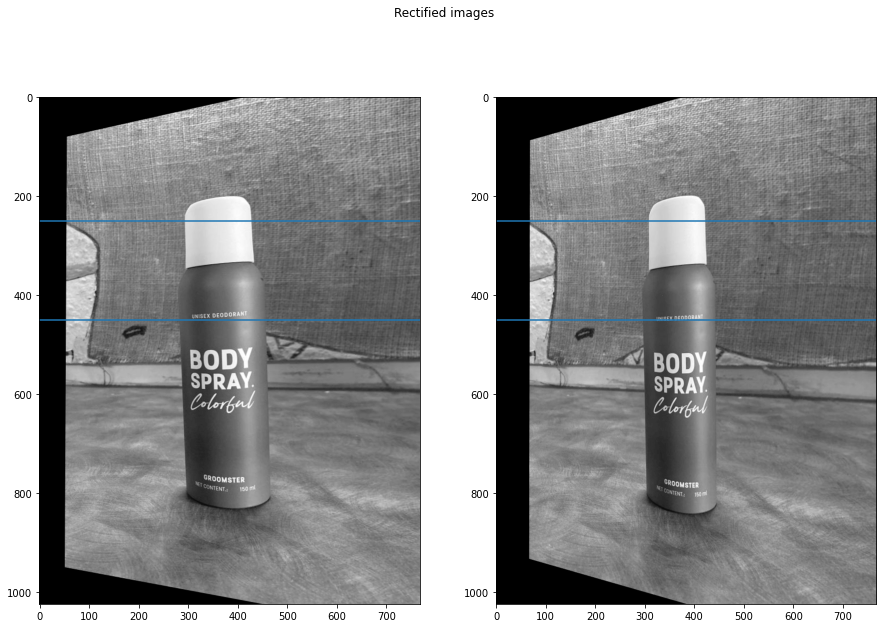

In [11]:
import  matplotlib.pyplot as plt


fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(rectified_1, cmap="gray")
axes[1].imshow(rectified_2, cmap="gray")
axes[0].axhline(250)
axes[1].axhline(250)
axes[0].axhline(450)
axes[1].axhline(450)
plt.suptitle("Rectified images")
plt.show()


## Disparity Map using SSD block method

In [14]:
def search_bounds(column, block_size):
    disparity_range = 75
    padding = block_size // 2
    right_bound = column
    
    left_bound = column - disparity_range
    if left_bound < padding:
        left_bound = padding
    
    return left_bound, right_bound, 1

In [17]:
def disparity_map(left, right, block_size, rshift):
    height, width = left.shape   
    d_map = np.zeros(left.shape , dtype=float)

    for row in range(height - block_size + 1):
        for col in range(width - block_size + 1):
            bestdist = float('inf')
            shift = 0
            left_pixel = left[row:row + block_size, col:col + block_size]
            l_bound, r_bound, step = search_bounds(col, block_size)

            for i in range(l_bound, r_bound, step):
                right_pixel = right[row:row + block_size, i:i + block_size]                
                ssd = np.sum((left_pixel - right_pixel) ** 2)
                if ssd < bestdist:
                    bestdist = ssd
                    shift = i

            if rshift:
                d_map[row, col] = col - shift
            else:
                d_map[row, col] = shift - col
            
    return d_map

In [18]:
left_img = cv2.resize(rectified_1, (0,0), fx=0.5, fy=0.5)
right_img = cv2.resize(rectified_2, (0,0), fx=0.5, fy=0.5)

dispMap = disparity_map(left_img, right_img, 4, rshift=True)

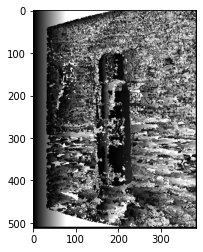

In [19]:
plt.imshow(dispMap, cmap='gray')

### Using Inbuilt SGM Algo for more accurate map

In [20]:

block_size = 4
min_disp = -128
max_disp = 128
num_disp = max_disp - min_disp
uniquenessRatio = 5
speckleWindowSize =400
speckleRange = 5
disp12MaxDiff = 0

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    uniquenessRatio=uniquenessRatio,
    speckleWindowSize=speckleWindowSize,
    speckleRange=speckleRange,
    disp12MaxDiff=disp12MaxDiff,
    P1=8 * 1 * block_size * block_size,
    P2=32 * 1 * block_size * block_size,
)
disparity_SGBM = stereo.compute(rectified_1, rectified_2)


disparity_SGBM = cv2.normalize(disparity_SGBM, disparity_SGBM, alpha=255,
                              beta=0, norm_type=cv2.NORM_MINMAX)
disparity_SGBM = np.uint8(disparity_SGBM)


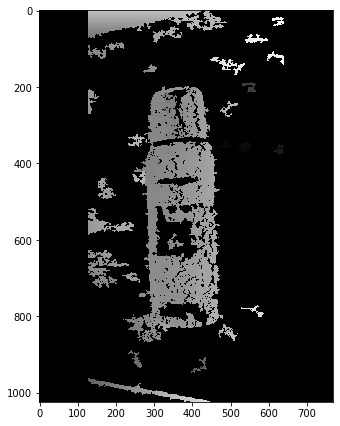

In [21]:
plt.figure(figsize = (10,7.2))
plt.imshow(disparity_SGBM, cmap="gray",  interpolation='nearest')